#### Import

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.cluster import KMeans

# Kmeans

İş Problemimiz : Amerikada işe girdik. Problem:

Bazı eyaletleri çeşitli suç istatistiklerine göre segmente etmek istiyoruz. Bu segmentlere göre bu eyaletlere bazı yaptırımlarda bulunmak istiyoruz. 

Buna yönelik olarak bütün eyaletleri tek tek yapmak zor, bunları bir veri bilimci aracılığıyla veri bilimciye diyoruz ki:

Biz sana değişkenleri verelim, sen bu değişkenlerin etkilerini göz önünde bulundurarak eyaletleri segmente et ve bize bir liste ver. Biz de o listeye göz gezdirerek nihai segmentlemeyi yapıp politikalarımızı geliştirelim.

Burada dikkat edilmesi gereken şey kümeleme sonunda oluşan segmentleri bir iş alanı profesiyoneline de kontrol ettirmek. Bizim örneğimizde bu şöyle olabilir: "Bu eyaletin etnik yapısı bu değişimlere izin vermeyebilir. Bunları bu segmentte bırakmayalım." 

## Veriyi İnceleme

In [3]:
#df = pd.read_csv('USArrests.csv',index_col=0).copy() index ismi olayı için optimum çözüm
df = pd.read_csv('USArrests.csv').copy()
df.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [4]:
df.index = df.iloc[:, 0]

In [5]:
df.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
Unnamed: 0,,,,,
Alabama,Alabama,13.2,236,58,21.2
Alaska,Alaska,10.0,263,48,44.5
Arizona,Arizona,8.1,294,80,31.0
Arkansas,Arkansas,8.8,190,50,19.5
California,California,9.0,276,91,40.6


In [6]:
df = df.iloc[:, 1:5]

In [7]:
df.head()

,Murder,Assault,UrbanPop,Rape
Unnamed: 0,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Gözlem birimlerinin İSİMLERİNİ index isimleri olarak atamak, proje sonrası çıktıları gözlemlerden yapıalcak optimizasyonların içindir.

In [8]:
df.index.name=""

In [9]:
df.head()

,Murder,Assault,UrbanPop,Rape
,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [10]:
# buraya kadarki index isimlendirme işlemi ilk satırda hallolabiliyor.

In [11]:
df.isnull().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [13]:
# 50 eyaleti 4 değişken bazında clusterlayacağız

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


Burada gördüğümüz suçlarda ortalaması en düşük olan Murder oluyor, bu suçun üstüne odaklanmak istersek:
1. Murder oranı %75'ten fazla olan eyaletler için yeni bir değişken oluşturup bu değişkende %75 üstüyse 1 altıysa 0 şeklinde murder'ın ağırlığını arttıracak bir değişken ekleme yapılabilir.
2. Murderin ölçeğiyle oynayarak da bunu yapabiliriz. Mesela 1-10 arasında bir ölçek ayarlayıp murder sayısı %75'in üstünde olanlara 10, %25'ten küçük olanlara 1 ve aradakilere de 3-5 gibi bir ölçek verdiğimizde murder'ın yüksek olduğu yerler iyice göze batacak şekilde kümelenecektir. (x-y etkenindeki gibi düşün).

Bunlar sayesinde murder değişkeninin gruplamadaki AĞIRLIĞINI elimizle ayarlayacak bir şekilde arttırmış oluyoruz. Bu kümeleme olayını mekaniklikten çıkartıp iş bilgisiyle de harmanlamaya yarıyor.

Burada şöyle bir örnek düşünebiliriz:

1. Elimizdeki verileri STANDARTLAŞTIRIP kümelemeye sokarsak iş bilgisi açısından çok kötü bir hamle yapmış oluyoruz (çünkü hepsinin max değerini 1 kabul etmiş oluyoruz) çünkü ölçek açısından farklarını yok sayıyoruz.
2. Şuanki haliyle de varyans açısından büyük değişkenlerin kümelemeye etkisi daha büyük olmuş olmakta. 
3. Yani kısaca bir x-y grafiğinde onun o değişkendeki değerinin onu götüreceği yeri düşünebiliriz. Mesela 1-10 arasında bir değer alıyorsa o değişken kümelemeyi 1-5 arası bir değer alandan daha az etkileyecektir.

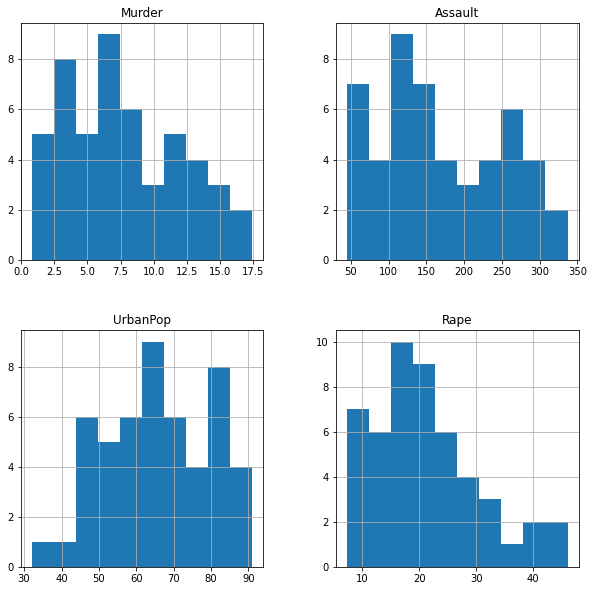

In [15]:
df.hist(figsize = (10,10));

Burada yukarıda gördüğümüz tepeleri ilkel bir segmentasyon açısından yorumlayabiliriz. Örneğin Murder'ın 10'dan sonraki yüksek kısımlarını oluşturan eyaletlere bakmak,5-7.5 arasındaki eyaletlere bakmak onları bir nevi gruplayacaktır.

## Model ve Görselleştirme

In [16]:
kmeans = KMeans(n_clusters = 4)
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [17]:
?kmeans

Type:        KMeans
String form: KMeans(n_clusters=4)
File:        ~/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py
Docstring:  
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centroids using sampling based on
    an empirical probability distribution of the points' contribution to the
    overall inertia. This technique speeds up convergence, and is
    theoretically proven to be :math:`\mathcal{O}(\log k)`-optimal.
    See the description of `n_init` for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an array is passed, it should be 

In [18]:
k_fit = kmeans.fit(df)

In [19]:
k_fit.n_clusters

4

In [20]:
k_fit.cluster_centers_

array([[ 11.8125    , 272.5625    ,  68.3125    ,  28.375     ],
       [  5.59      , 112.4       ,  65.6       ,  17.27      ],
       [  2.95      ,  62.7       ,  53.9       ,  11.51      ],
       [  8.21428571, 173.28571429,  70.64285714,  22.84285714]])

In [21]:
k_fit.labels_ # hangi eyaletin hangi sınıfa (cluster'a) girdiğini görüyoruz

array([0, 0, 0, 3, 0, 3, 1, 0, 0, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 3, 0,
       2, 0, 3, 1, 1, 0, 2, 3, 0, 0, 0, 2, 1, 3, 3, 1, 3, 0, 2, 3, 3, 1,
       2, 3, 3, 2, 2, 3], dtype=int32)

*Kümeleme işlemi aslında labels_'ı alınca bitiyor, ama bu inceleme için yeterli olmayabilir. o yüzden görselleştirmeyle devam*

In [22]:
# Görselleştirme Vakti

In [23]:
kmeans = KMeans(n_clusters = 2)
k_fit = kmeans.fit(df)

In [24]:
kumeler = k_fit.labels_ #k_fit.labels_ == kmeans.labels_

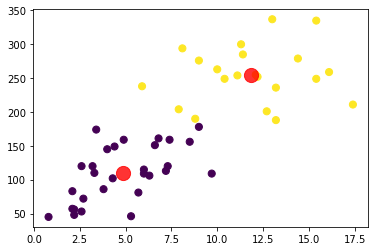

In [25]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c = kumeler, s = 50, cmap = "viridis");

merkezler = k_fit.cluster_centers_

plt.scatter(merkezler[:, 0], merkezler[:, 1], c = "red", s = 200, alpha = 0.8);

Veri setini 2 değişkene indirgeyip bu 2 değişken üzerinden kümeleri görselleştirdik. Bunu neden yaptık?

Veriyi 2 boyutta gösterebilmenin 2 yolu var:
1. 2 tane değişken seçip bunları göstermek.
2. PCA uygulamak! -> Boyut indirgemesi yapıp görselleştirme yapmak.

In [26]:
df.head() # yukarda murder ve assault'a göre 2 kümeye ayırmış olduk.

,Murder,Assault,UrbanPop,Rape
,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [27]:
# 3 boyutlu görselleştirmek istersek?

In [28]:
from mpl_toolkits.mplot3d import Axes3D
# çalışmazsa bu şekilde düzelebilir:
#!pip install --upgrade matplotlib
#import mpl_toolkits

In [29]:
kmeans = KMeans(n_clusters = 3)
k_fit = kmeans.fit(df)
kümeler = k_fit.labels_
merkezler = k_fit.cluster_centers_

In [30]:
kümeler

array([2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2,
       1, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0], dtype=int32)

In [31]:
# şimdi 3 boyutlu bir scatterplot oluşturma işlemi yapacağız

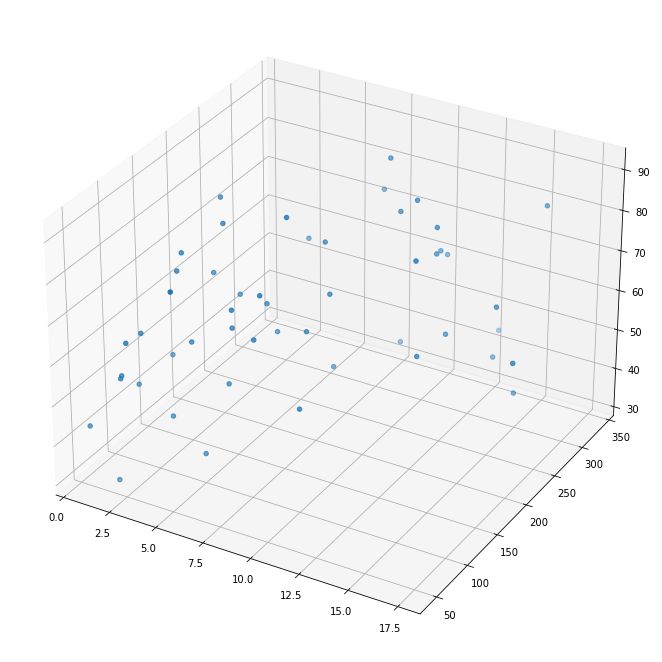

In [32]:
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]);

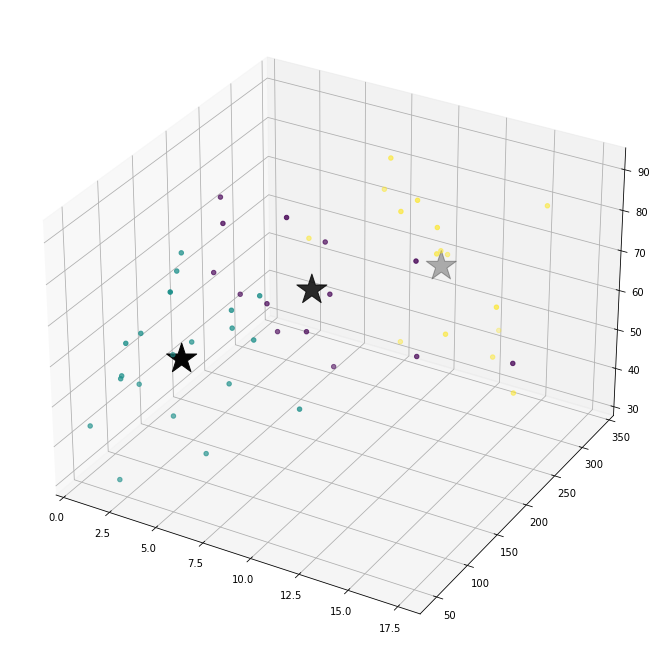

In [33]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], c=kümeler)
ax.scatter(merkezler[:, 0], merkezler[:, 1], merkezler[:, 2], 
           marker='*', 
           c='#050505', 
           s=1000);

Elimizde 10-15'e kadar değiken olabilir.

Bu durumda yine de görselleştirme yapmak istiyorsanız:
1. Elinizdeki değişkenlere PCA uygulamalısınız (bilgi kayıplarını göz önüne alarak)
2. İndirgeme işleminden sonra 2 eksen üzerinde bu yeni bileşenlerle birlikte görselleştirme yapıp
3. Gözlem birimlerini grafiğe bağlayıp

Benzer bir görselleştirme işlemi çok sayıda değişkenle gerçekleştirilebilir.

## Şimdi asıl olaya geliyoruz, Hangi eyalet hangi kümede?

In [34]:
# kümeler ve gözlem birimleri

In [35]:
kmeans = KMeans(n_clusters = 3)
k_fit = kmeans.fit(df)
kümeler = k_fit.labels_

In [36]:
pd.DataFrame({"Eyaletler": df.index, "Clusters": kümeler}).head(10)

,Eyaletler,Clusters
0,Alabama,1
1,Alaska,1
2,Arizona,1
3,Arkansas,0
4,California,1
5,Colorado,0
6,Connecticut,2
7,Delaware,1
8,Florida,1
9,Georgia,0


In [37]:
# burada en öncelikli problemimiz bu eyaletleri dataframe'de bu şekilde görmekti.

In [38]:
# ana veri setimize de bu kümeleri eklemek istersek:

In [39]:
df["cluster_no"] = kümeler

In [40]:
df.head()

,Murder,Assault,UrbanPop,Rape,cluster_no
,,,,,
Alabama,13.2,236,58,21.2,1
Alaska,10.0,263,48,44.5,1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1


In [41]:
# daha gerçekçi gözlemler için 0 değil de 1'den kümelerin başlamasını istersek:

In [42]:
df["cluster_no"] = df["cluster_no"] + 1

In [43]:
df.head()

,Murder,Assault,UrbanPop,Rape,cluster_no
,,,,,
Alabama,13.2,236,58,21.2,2
Alaska,10.0,263,48,44.5,2
Arizona,8.1,294,80,31.0,2
Arkansas,8.8,190,50,19.5,1
California,9.0,276,91,40.6,2


## Optimum Küme sayımızı nasıl bulacağız ?

In [44]:
# Bir nevi KMeans modelinin tuning aşamasındayız denebilir.

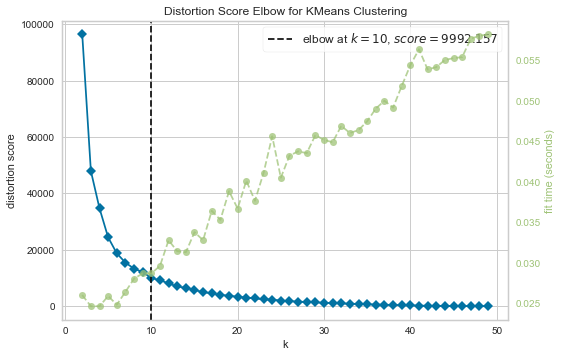

In [45]:
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,50))
visualizer.fit(df) 
visualizer.poof();

Bu grafiğin yorumu:
1. KMeans ve hiyerarşik kümeleme yöntemleri gibi kümeleme yöntemleri kullanılırken İŞ BİLGİSİNİ göz önünde bulundurarak segmentasyon yapılmalıdır.
2. Segmentasyon odaklı bir kümeleme analizi yapıyorsak, yani asıl amacımız bir grubu segmente etmek ise bu durumda SEGMENT ANLAMINI iyi düşünmek gerekiyor. Segment dediğimiz şey genelde 2-5 civaro bir sayıda olur.
3. Ya da ana bir kırılım olur örneğin kredi kartı kullananlar ve kullanmayanlar. Bu durumda kredi kartı kullananların iÇİNDEN 3-5 segment, kullanmayanların İÇİNDEN 3-5 segment oluşturulabilir.

Yani segmentasyon temelde bizim odağımızı iş gücü veya para kaynaklı bölmeye yaramaktadır. Örneğin 10.000 müşterimiz varsa: Bunların hepsiyle 100 kişilik bir müşteri ilişkileri departmanıyla ilgilenemem. Burada yapacağım şey bana en çok kazanç ve katkı sağlayacak kişileri belirli metriklerle segmente etmeliyim.

Bu işlemden sonra bu 100 kişiyi platinium, gold gibi müşteri gruplarına ayırıp enerjilerini müşteri seviyesine göre belirleyebiliriz. Bunu göz yordamıyla yapmak zor olacağından nümerik olarak yapıyoruz burada.

Bu sebeplerden dolayı KMeans'i mekanik problem için değil de iş bilgisi gerektiren bir segmentasyon vb problem için kullanıyorsak, bu durumda elbow yöntemi yani hata değerlerinin bize sunduğu şey bir *KARAR DESTEK NOKTASI*'dır. 

Yani burada kararı verirken SADECE düşük hata değerine göre bakıp iş bilgisini göz ardı edersek başarısız oluruz.

In [46]:
# Yukarıdaki yorumlar ve bilgilere dayanarak optimum küme sayısını 6 olarak buldum.
# 7 yaparsam iş yükü artışı hata azalmasına değmeyecek bir seviyede.

In [47]:
# Final Model oluşumu

In [48]:
kmeans = KMeans(n_clusters = 6)
k_fit = kmeans.fit(df)
kümeler = k_fit.labels_

In [49]:
pd.DataFrame({"Eyaletler": df.index, "Clusters": kümeler}).head(10)

,Eyaletler,Clusters
0,Alabama,1
1,Alaska,1
2,Arizona,5
3,Arkansas,4
4,California,1
5,Colorado,4
6,Connecticut,3
7,Delaware,1
8,Florida,5
9,Georgia,4


Bu noktadan sonra bunları bir excel'e döküp, excelde bunları segmentlere göre renklendirip,

"Ben senin çalışmanı bitirdim. Müşterilerin belirli değerine karşılık (aylık bıraktıkları gelir, websitesi ziyaret miktarı) müşterileri segmente ettim ,excele döktüm, renklendirdim. İşte sana eyaletler, müşteriler ve segmentleri. *Bunları sıralayadabilirim gerekiyorsa*. (burada sıralama sınıflar arası farklılıkları göz önüne alarak hiyerarşik bir yapı oluşturma gibi düşünülebilir.)"

In [53]:
# how to visualize the final result?